In [35]:
# ============================================================
# Healthcare Risk Classification - A Machine Learning Approach
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

In [36]:
# ------------------------------------------------------------
# 1. Load Cleaned Dataset
# ------------------------------------------------------------
df = pd.read_csv("../data/processed/cleaned_dataset.csv")

# Features & Target
X = df.drop([
    "risk_category",
    "risk_score",
    "length_of_stay",
    "total_claim_cost"
], axis=1)

y = df["risk_category"]


In [37]:
# ------------------------------------------------------------
# 2. Encode Target (IMPORTANT for XGBoost)
# ------------------------------------------------------------
le = LabelEncoder()
y = le.fit_transform(y)

In [38]:
# ------------------------------------------------------------
# 3. Convert categorical variables
# ------------------------------------------------------------
X = pd.get_dummies(X, drop_first=True)

In [39]:
# ------------------------------------------------------------
# 4. Train-Test Split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [40]:
# ------------------------------------------------------------
# 5. Scaling (for Logistic & MLP)
# ------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
#============================================================
# 6. Train Models
# ============================================================

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)

# XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)

# MLP
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    max_iter=500,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)

e:\healthai\.venv\lib\site-packages\xgboost\training.py:200: UserWarning: [19:09:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [42]:
# ============================================================
# 7. Evaluation Metrics
# ============================================================

# Accuracy
acc_log = accuracy_score(y_test, y_pred_log)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
acc_mlp = accuracy_score(y_test, y_pred_mlp)

# F1 Score
f1_log = f1_score(y_test, y_pred_log, average="weighted")
f1_xgb = f1_score(y_test, y_pred_xgb, average="weighted")
f1_mlp = f1_score(y_test, y_pred_mlp, average="weighted")

# ROC-AUC (multi-class)
roc_log = roc_auc_score(y_test, y_prob_log, multi_class="ovr", average="weighted")
roc_xgb = roc_auc_score(y_test, y_prob_xgb, multi_class="ovr", average="weighted")
roc_mlp = roc_auc_score(y_test, y_prob_mlp, multi_class="ovr", average="weighted")


# Cross Validation (5-fold F1)
cv_log = cross_val_score(log_model, X_train_scaled, y_train,
                         cv=5, scoring="f1_weighted").mean()

cv_xgb = cross_val_score(xgb_model, X_train, y_train,
                         cv=5, scoring="f1_weighted").mean()

cv_mlp = cross_val_score(mlp_model, X_train_scaled, y_train,
                         cv=5, scoring="f1_weighted").mean()

e:\healthai\.venv\lib\site-packages\xgboost\training.py:200: UserWarning: [19:09:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\healthai\.venv\lib\site-packages\xgboost\training.py:200: UserWarning: [19:09:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\healthai\.venv\lib\site-packages\xgboost\training.py:200: UserWarning: [19:09:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\healthai\.venv\lib\site-packages\xgboost\training.py:200: UserWarning: [19:09:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [43]:
# ============================================================
# 8. Comparison Table
# ============================================================

results = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost", "MLP"],
    "Accuracy": [acc_log, acc_xgb, acc_mlp],
    "F1 Score": [f1_log, f1_xgb, f1_mlp],
    "ROC-AUC": [roc_log, roc_xgb, roc_mlp],
    "CV F1 Score": [cv_log, cv_xgb, cv_mlp]
})

results = results.sort_values(by="ROC-AUC", ascending=False)

print("\n================ MODEL COMPARISON ================")
print(results)


================ MODEL COMPARISON ================
                 Model  Accuracy  F1 Score   ROC-AUC  CV F1 Score
1              XGBoost     0.959  0.958545  0.994494     0.948714
0  Logistic Regression     0.906  0.905153  0.972384     0.889835
2                  MLP     0.866  0.865219  0.965985     0.870476


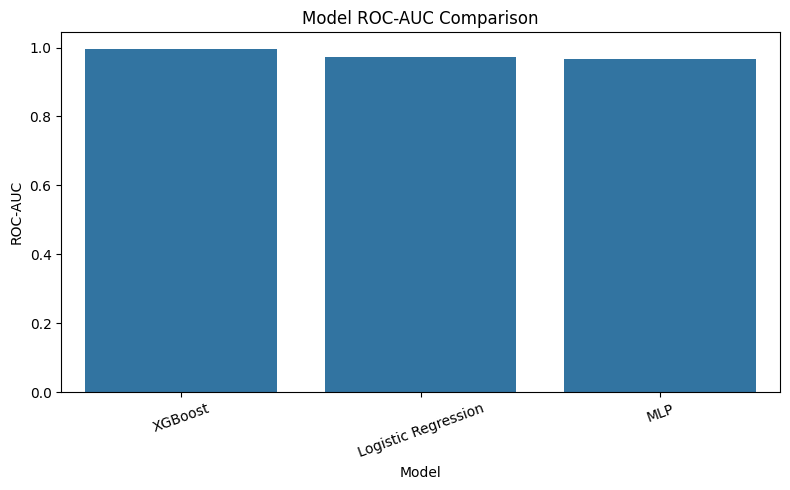

In [44]:
# ============================================================
# 9. Comparison Chart
# ============================================================

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="ROC-AUC", data=results)
plt.title("Model ROC-AUC Comparison")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [45]:
# ============================================================
# 10. Best Model Selection
# ============================================================

best_model_name = results.iloc[0]["Model"]
print("\nBest Model Based on ROC-AUC:", best_model_name)


Best Model Based on ROC-AUC: XGBoost
